In [6]:
import torchshow
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import h5py
import io

import cv2
from pathlib import Path


class HDF5Dataset(Dataset):
    def __init__(self, hdf5_path, meta_df, transform=None):
        self.hdf5_path = h5py.File(hdf5_path, "r")
        self.meta_df = meta_df
        self.transform = transform

    def __len__(self):
        return len(self.meta_df)

    def __getitem__(self, idx):
        img_name = self.meta_df.loc[idx, "isic_id"]

        image = np.array(self.hdf5_path[img_name])
        image = np.array(Image.open(io.BytesIO(image)), dtype=np.float32) / 255

        # label = int(self.meta_df["target"].iloc[idx])

        if self.transform:
            image = self.transform(image=image)["image"]

        return (
            image,
            # label,
        )

In [12]:
# hdf5_path = "/kaggle/input/isic-2024-challenge/train-image.hdf5"
# meta_path = "/kaggle/input/isic-2024-challenge/train-metadata.csv"
hdf5_path = "/kaggle/input/isic_archive_malignant_resized/train_image.hdf5"
meta_path = "/kaggle/input/isic_archive_malignant_resized/metadata.csv"


def gen_dataloader(hdf5_path, meta_path, mal_only=False):
    meta_df = pd.read_csv(meta_path)
    if mal_only:
        meta_df = meta_df[meta_df["target"] != 0]
    meta_df = meta_df.reset_index(drop=True)
    train_transform = A.Compose(
        [
            A.Resize(height=224, width=224),
            ToTensorV2(),
        ]
    )

    train_dataset = HDF5Dataset(hdf5_path, meta_df, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=45, shuffle=True)
    return train_loader


train_loader = gen_dataloader(hdf5_path, meta_path, False)

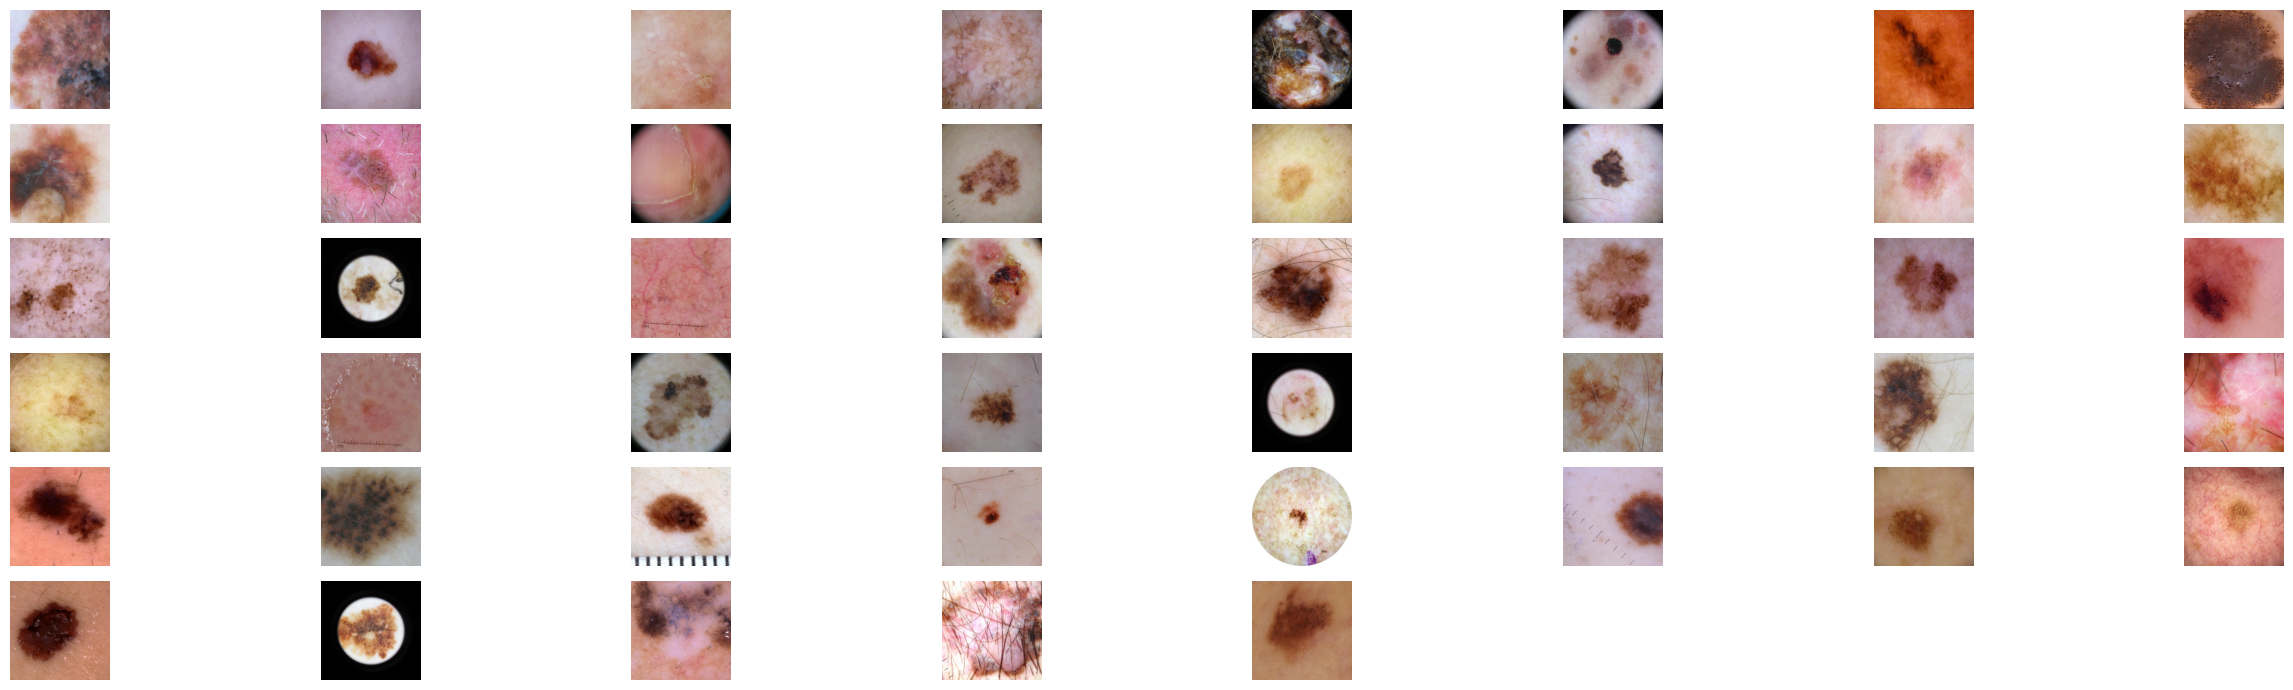

In [13]:
for d in train_loader:
    torchshow.show(d[0], figsize=(25, 7), nrow=15, ncol=3)
    break